In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv2

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_dir = './images/train'
train_dir_pos = os.path.join(train_dir, 'positive')
train_dir_neg = os.path.join(train_dir, 'negative')
# test_dir = './images/test'
# test_dir_pos = os.path.join(test_dir, 'positive')
# test_dir_neg = os.path.join(test_dir, 'negative')
# valid_dir = './images/validation'
# valid_dir_pos = os.path.join(valid_dir, 'positive')
# valid_dir_neg = os.path.join(valid_dir, 'negative')

In [3]:
num_pos_train = len(os.listdir(train_dir_pos))
num_neg_train = len(os.listdir(train_dir_neg))
# num_pos_test = len(os.listdir(test_dir_pos))
# num_neg_test = len(os.listdir(test_dir_neg))
# num_pos_valid = len(os.listdir(valid_dir_pos))
# num_neg_valid = len(os.listdir(valid_dir_neg))

total_train = num_pos_train + num_neg_train
# total_valid= num_pos_test+ num_neg_test
# total_test = num_pos_test + num_neg_test

In [4]:
720/1080
1080/1920

0.5625

(64, 64, 3)
1.0


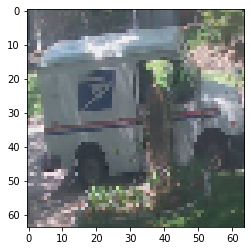

In [46]:
#train = cv2.imread('./images/positive/pos5.jpg')
train = cv2.imread('./images/positive/pos43.jpg')

def processImg(img):
    #print(img.shape)
    img = cv2.resize(img, (720,int(1080*(1080/1920))))
    img = img[130:330,200:400]
    img_size_h = int(64*img.shape[0]/img.shape[1])
    img = cv2.resize(img,(64, img_size_h))
    return img

def processFolder(datapath):
    data = os.listdir(datapath)
    num_data = len(data)
    for i in range(num_data):
        data[i] = processImg(cv2.imread(str(datapath+"/"+data[i])))
    return data

truck = processImg(train)
print(truck.shape)
print(truck.shape[0]/truck.shape[1])
256*truck.shape[0]/truck.shape[1]
rgb = cv2.cvtColor(truck, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

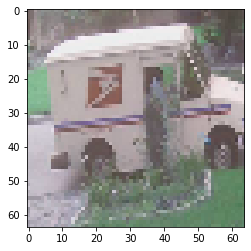

In [47]:
data_train = np.array(processFolder(train_dir_pos))
plt.imshow(data_train[0])
plt.imshow(data_train[2])

In [48]:
batch_size = 32
img_size_w = data_train[0].shape[1]
img_size_h = data_train[0].shape[0]
print(img_size_w)
print(img_size_h)

64
64


In [49]:
img_generator = ImageDataGenerator()

In [50]:
train_img_gen = img_generator.flow(data_train,
                                   batch_size = batch_size, 
                                   shuffle = True)

# valid_img_gen = img_generator.flow_from_directory(batch_size = batch_size, 
#                                                   directory = valid_dir, 
#                                                   shuffle = False, 
#                                                   target_size=(img_size_h,img_size_w),
#                                                   class_mode = 'binary')
# test_img_gen =  img_generator.flow_from_directory(batch_size = batch_size, 
#                                                   directory = test_dir, 
#                                                   shuffle = False, 
#                                                   target_size=(img_size_h,img_size_w),
#                                                   class_mode = 'binary')

(<AxesSubplot:title={'center':'train'}>,
 Text(0.5, 1.0, 'train'),
 ([], []),
 ([], []))

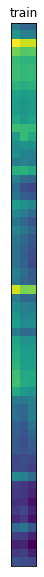

In [51]:
train = train_img_gen[0][0][0]
# test = test_img_gen[0][0][0]
# valid = valid_img_gen[0][0][0]

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(train), plt.title("train"), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(test), plt.title("test"), plt.xticks([]), plt.yticks([])
# plt.figure(figsize=(10,10))
# plt.subplot(121), plt.imshow(valid), plt.title("valid"), plt.xticks([]), plt.yticks([])

In [1]:
inp = layers.Input(shape=(img_size_w, img_size_h, 3))

# Convolution layers to help learn some basic kernels
pre_conv = layers.Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation='relu')(inp)

# Down sampling
down_sample_0 = layers.Conv2D(16, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(pre_conv)
down_sample_1 = layers.Conv2D(24, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(down_sample_0)
down_sample_2 = layers.Conv2D(24, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(down_sample_1)

# Most compressed layer in the network
latent = layers.Conv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(down_sample_2)

# Upsampling with skip connections
up_sample_0 = layers.Conv2DTranspose(24, (3, 3), strides=(2,2), padding='same', activation='relu')(latent)
skip_0 = layers.Concatenate()([up_sample_0, down_sample_2])

up_sample_1 = layers.Conv2DTranspose(24, (3, 3), strides=(2,2), padding='same', activation='relu')(skip_0)
skip_1 = layers.Concatenate()([up_sample_1, down_sample_1])

up_sample_2 = layers.Conv2DTranspose(16, (3, 3), strides=(2,2), padding='same', activation='relu')(skip_1)
skip_2 = layers.Concatenate()([up_sample_2, down_sample_0])

up_sample_3 = layers.Conv2DTranspose(16, (3, 3), strides=(2,2), padding='same', activation='relu')(skip_2)
skip_3 = layers.Concatenate()([up_sample_3, pre_conv])

# Post convolution layers
post_conv = layers.Conv2DTranspose(8, (3, 3), strides=(1, 1), padding='same', activation='relu')(skip_3)

output = layers.Conv2DTranspose(1, (1, 1), strides=(1,1), padding='same', activation='sigmoid')(post_conv)
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = models.Model(inputs=inp, outputs=output)

# Bind the optimizer and the loss function to the model
model.compile(optimizer='adam',
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

NameError: name 'layers' is not defined

In [53]:
print(data_train[0].shape)
fit_result = model.fit(data_train, 
                       steps_per_epoch = int(np.ceil(total_train/float(batch_size))),
                       epochs = 15,
                       validation_data = valid_img_gen,
                       validation_steps = int(np.ceil(total_train/float(batch_size)))
                      )

(64, 64, 3)
Epoch 1/15


ValueError: in user code:

    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:598 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /home/pb/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:78 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d_15/kernel:0', 'conv2d_15/bias:0', 'conv2d_16/kernel:0', 'conv2d_16/bias:0', 'conv2d_17/kernel:0', 'conv2d_17/bias:0', 'conv2d_18/kernel:0', 'conv2d_18/bias:0', 'conv2d_19/kernel:0', 'conv2d_19/bias:0', 'conv2d_transpose_14/kernel:0', 'conv2d_transpose_14/bias:0', 'conv2d_transpose_15/kernel:0', 'conv2d_transpose_15/bias:0', 'conv2d_transpose_16/kernel:0', 'conv2d_transpose_16/bias:0', 'conv2d_transpose_17/kernel:0', 'conv2d_transpose_17/bias:0', 'conv2d_transpose_18/kernel:0', 'conv2d_transpose_18/bias:0', 'conv2d_transpose_19/kernel:0', 'conv2d_transpose_19/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0'].


In [20]:
print(fit_result.history['binary_accuracy'])

[0.5285714268684387, 0.5, 0.4714285731315613, 0.5357142686843872, 0.6142857074737549, 0.7071428298950195, 0.8571428656578064, 0.8571428656578064, 0.8500000238418579, 0.8500000238418579, 0.8571428656578064, 0.8500000238418579, 0.8714285492897034, 0.9071428775787354, 0.8642857074737549]


In [21]:
model.save_weights('model.h5')

In [22]:
test_img_gen.reset()

pred = model.predict(test_img_gen, steps=total_test/batch_size, verbose=1)

predicted_class_indices = np.round(pred)

labels = (train_img_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k[0]] for k in predicted_class_indices]

filenames = test_img_gen.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
correct = 0
incorrect = 0
for index, value in results.iterrows():
    filename = value[0].split('/')[0]
    prediction_value = value[1]
    print("file: ", value[0], " prediction: ", prediction_value)
    if (filename == prediction_value):
        correct = correct + 1
    else:
        incorrect = incorrect + 1

print(correct)
print(incorrect)
print('Accuracy on the test data: ' + str(round((correct/total_test)*100, 1)) + '%')



3/3 [==============================] - 4s 851ms/step
file:  negative/neg (101).jpg  prediction:  negative
file:  negative/neg (102).jpg  prediction:  negative
file:  negative/neg (103).jpg  prediction:  negative
file:  negative/neg (104).jpg  prediction:  negative
file:  negative/neg (105).jpg  prediction:  positive
file:  negative/neg (106).jpg  prediction:  negative
file:  negative/neg (107).jpg  prediction:  negative
file:  negative/neg (108).jpg  prediction:  negative
file:  negative/neg (109).jpg  prediction:  negative
file:  negative/neg (110).jpg  prediction:  negative
file:  negative/neg (111).jpg  prediction:  negative
file:  negative/neg (112).jpg  prediction:  negative
file:  negative/neg (113).jpg  prediction:  negative
file:  negative/neg (114).jpg  prediction:  negative
file:  negative/neg (115).jpg  prediction:  negative
file:  negative/neg (116).jpg  prediction:  negative
file:  negative/neg (117).jpg  prediction:  negative
file:  negative/neg (118).jpg  prediction:  ne